## Which neiborhood in Chicago shall I open a new cafe? ;) 


In [1]:
import pandas as pd
import numpy as np
import math
import json
import requests
from geopy.geocoders import Nominatim
from pandas import json_normalize  
import folium
import wget
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
    #from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
    #from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans


In [2]:
#--just set the location to Chicago
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode("Chicago, IL")
print(location)
loc_lat = location.latitude
loc_lng = location.longitude
print(loc_lat, loc_lng)

Chicago, Cook County, Illinois, United States of America
41.8755616 -87.6244212


## Section 1: Gathering, and Processing of Raw Data

#### Data include:
<li>Chicago geo data: ward(neighborhood) and it's coordinate </li> 
<li>CTA public transportation: CTA L Trains stops, station name and coordinate</li> 
<li>Divvy: Chicago bike share, station coordinate</li>
<li>Crime: City Crima record, crime type and coordinate</li>
<li>foursquare dataset: split venue into retail(including goods and service) and enviroment(including public recreational area) </li>




In [3]:
#--get json ward data, normalize it, and reformat coordinates.  because crime data has ward, so use ward

#chicago_boundray = requests.get("https://data.cityofchicago.org/resource/y6yq-dbs2.json").json()

chicago_ward = requests.get("https://data.cityofchicago.org/resource/k9yb-bpqx.json").json()


chicago_geo = json_normalize(chicago_ward)#.drop(["the_geom.type"], axis = 1)

chicago_geo["lat"] = [chicago_geo["the_geom.coordinates"][ind][0][0][0][1] for ind in np.arange(0,len(chicago_geo))]
chicago_geo["lng"] = [chicago_geo["the_geom.coordinates"][ind][0][0][0][0] for ind in np.arange(0,len(chicago_geo))]


print(chicago_geo.loc[[2], ["lat","lng"]],chicago_geo["the_geom.coordinates"][2][0][0][0])
#--looks like just rounded 
chicago_geo["ward"]=chicago_geo["ward"].astype("int")
chicago_geo.drop(["the_geom.coordinates","the_geom.type"], axis = 1, inplace = True)
chicago_geo = chicago_geo.sort_values(by = "ward", ascending = True).reset_index(drop = True)
chicago_geo["ward"].unique() #--50
chicago_geo.head()

         lat        lng
2  41.817294 -87.698175 [-87.69817510963803, 41.81729440755995]


,ward,shape_leng,shape_area,lat,lng
0,1,102569.70148,69757593.8542,41.928632,-87.678178
1,2,110739.852187,53934808.8716,41.927232,-87.661367
2,3,81530.2751668,123341548.953,41.855424,-87.618215
3,4,119468.403755,126006901.096,41.873357,-87.625971
4,5,102271.665896,115196005.523,41.805851,-87.583365


In [4]:
#--get CTA L train stops 

chicago_cta = pd.read_json("https://data.cityofchicago.org/resource/zbnc-zirh.json")[["station_name","location"]]



chicago_cta["lat"] = [chicago_cta["location"][loc]["latitude"] for loc in (np.arange(0, len(chicago_cta)))]
chicago_cta["lng"] = [chicago_cta["location"][loc]["longitude"] for loc in (np.arange(0, len(chicago_cta)))]


chicago_cta_stops = chicago_cta[["station_name","lat","lng"]].drop_duplicates(ignore_index = True)
chicago_cta_stops[["lat"]] = chicago_cta_stops[["lat"]].astype(float)
chicago_cta_stops[["lng"]] = chicago_cta_stops[["lng"]].astype(float)
#chicago_cta_stops.dtypes
chicago_cta_stops.head()


,station_name,lat,lng
0,18th,41.857908,-87.669147
1,35th/Archer,41.829353,-87.680622
2,35th-Bronzeville-IIT,41.831677,-87.625826
3,43rd,41.816462,-87.619021
4,47th,41.809209,-87.618826


In [164]:
#--define how to calculate distance 


def distance(lat1, lon1,  lat2, lon2):
    radius = 6371  #--km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2)*math.sin(dlat/2)+math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)*math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d


In [6]:
#--calculate how many L train stops around each ward are within walking distance, and append to chicago_geo

walking_dist = 2
cols = ["ward", "stops","dist"]
dist_list = []
    
for row in np.arange(0,len(chicago_geo)):
    lat1 = chicago_geo["lat"][row]
    lng1 = chicago_geo["lng"][row]
    ward = chicago_geo["ward"][row]              
    for row_cta in np.arange(0,len(chicago_cta_stops)):
        lat2 = chicago_cta_stops["lat"][row_cta]
        lng2 = chicago_cta_stops["lng"][row_cta]
        stops = chicago_cta_stops["station_name"][row_cta]   
        dist = distance(lat1, lng1,  lat2, lng2)
        dist_list.append((ward, stops, dist))
    dist_df = pd.DataFrame(dist_list, columns = cols)
    dist_cnt = dist_df[dist_df["dist"] < walking_dist]
    dist_cnt = dist_cnt[["ward","stops"]].groupby("ward").count().reset_index().sort_values(by = "ward") 
chicago_geo_cta = pd.merge(chicago_geo, dist_cnt, on = "ward", how = "left").fillna(0)
  

chicago_geo_cta.head()

,ward,shape_leng,shape_area,lat,lng,stops
0,1,102569.70148,69757593.8542,41.928632,-87.678178,3.0
1,2,110739.852187,53934808.8716,41.927232,-87.661367,7.0
2,3,81530.2751668,123341548.953,41.855424,-87.618215,4.0
3,4,119468.403755,126006901.096,41.873357,-87.625971,22.0
4,5,102271.665896,115196005.523,41.805851,-87.583365,0.0


In [7]:
#--get divvy bike station!

chicago_divvy = pd.read_json("https://data.cityofchicago.org/resource/bk89-9dk7.json")[["station_name","latitude","longitude"]]


chicago_divvy[["latitude"]] = chicago_divvy[["latitude"]].astype(float)
chicago_divvy[["longitude"]] = chicago_divvy[["longitude"]].astype(float)
chicago_divvy.dtypes
chicago_divvy.head()


,station_name,latitude,longitude
0,Ellis Ave & 53rd St,41.799336,-87.600958
1,Shedd Aquarium,41.867226,-87.615355
2,Kimbark Ave & 53rd St,41.799568,-87.594747
3,Montrose Harbor,41.963982,-87.638181
4,Benson Ave & Church St,42.048214,-87.683485


In [8]:
#--calculate how many divvy stations around each ward are within walking distance, and append to chicago_geo

walking_dist = 2
cols = ["ward", "stastion","dist"]
dist_list2 = []
    
for row in np.arange(0,len(chicago_geo)):
    lat1 = chicago_geo["lat"][row]
    lng1 = chicago_geo["lng"][row]
    ward = chicago_geo["ward"][row]              
    for row_divvy in np.arange(0,len(chicago_divvy)):
        lat2 = chicago_divvy["latitude"][row_divvy]
        lng2 = chicago_divvy["longitude"][row_divvy]
        station = chicago_divvy["station_name"][row_divvy]   
        dist = distance(lat1, lng1,  lat2, lng2)
        dist_list2.append((ward, station, dist))
    dist_df = pd.DataFrame(dist_list2, columns = cols)
    dist_cnt = dist_df[dist_df["dist"] < walking_dist]
    dist_cnt = dist_cnt[["ward","stastion"]].groupby("ward").count().reset_index().sort_values(by = "ward") 
    chicago_geo_cta_divvy = pd.merge(chicago_geo_cta, dist_cnt, on = "ward", how = "left").fillna(0)

chicago_geo_cta_divvy.head()

,ward,shape_leng,shape_area,lat,lng,stops,stastion
0,1,102569.70148,69757593.8542,41.928632,-87.678178,3.0,36.0
1,2,110739.852187,53934808.8716,41.927232,-87.661367,7.0,49.0
2,3,81530.2751668,123341548.953,41.855424,-87.618215,4.0,26.0
3,4,119468.403755,126006901.096,41.873357,-87.625971,22.0,76.0
4,5,102271.665896,115196005.523,41.805851,-87.583365,0.0,16.0


In [9]:
#--get crime rate data 

chicago_crime = pd.read_json("https://data.cityofchicago.org/resource/dfnk-7re6.json")
#print(chicago_crime["date_of_occurrence"].min(), chicago_crime["date_of_occurrence"].max())
#--this is crime rate from 2019-06-01 to 2020-04-27

chicago_crime = chicago_crime[["ward","date_of_occurrence","_primary_decsription","latitude","longitude","_location_description"]].sort_values(by = "ward")

chicago_crime.head()

,ward,date_of_occurrence,_primary_decsription,latitude,longitude,_location_description
446,1,2019-09-01T15:23:00.000,THEFT,41.918432,-87.690032,DEPARTMENT STORE
495,1,2019-09-05T00:50:00.000,CRIMINAL DAMAGE,41.929633,-87.678777,STREET
608,1,2019-11-03T20:40:00.000,THEFT,41.929744,-87.684274,DEPARTMENT STORE
956,1,2019-11-03T20:13:00.000,NARCOTICS,41.914877,-87.699227,STREET
597,1,2019-09-05T20:00:00.000,THEFT,41.910117,-87.677445,CTA TRAIN


In [10]:
#---group by for the ward, then add a total for crime 

ch_crime_group = chicago_crime[["ward","date_of_occurrence","_primary_decsription"]].groupby(["ward","_primary_decsription"], as_index = False).count()

ch_crime_group.rename(columns = {"_primary_decsription":"primary_decsription","date_of_occurrence":"cnt"}, inplace = True)
ch_crime_ward = ch_crime_group.pivot(index="ward", columns = "primary_decsription").fillna(0)

ch_crime_ward.columns = [ch_crime_ward.columns[col][-1] for col in np.arange(0, len(ch_crime_ward.columns))] 
ch_crime_ward["Total"] = ch_crime_ward.sum(axis = 1)

ch_crime_ward.head()

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PROSTITUTION,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Total
ward,,,,,,,,,,,,,,,,,,,,,
1,0.0,2.0,2.0,0.0,0.0,0.0,4.0,0.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,28.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,22.0
3,0.0,3.0,5.0,2.0,0.0,0.0,5.0,0.0,1.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,25.0
4,0.0,1.0,4.0,0.0,0.0,0.0,9.0,0.0,1.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,34.0
5,0.0,1.0,5.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,...,0.0,3.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,25.0


In [11]:
#--append the total and relevant crime to chicago geo data

chicago_geo_tot = pd.merge(chicago_geo_cta_divvy, ch_crime_ward[["ROBBERY","BURGLARY","THEFT","Total"]], on = "ward", how = "left")

chicago_geo_tot.rename(columns = {"stops":"LTrain_Stop_cnt", "stastion":"Divvy_Station_cnt", "ROBBERY":"C_Robbery_cnt", 
                        "BURGLARY":"C_Burglary_cnt", "THEFT":"C_Theft_cnt", "Total":"C_Total_cnt"}, inplace = True)

chicago_geo_tot.head()

,ward,shape_leng,shape_area,lat,lng,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt
0,1,102569.70148,69757593.8542,41.928632,-87.678178,3.0,36.0,0.0,0.0,13.0,28.0
1,2,110739.852187,53934808.8716,41.927232,-87.661367,7.0,49.0,0.0,0.0,13.0,22.0
2,3,81530.2751668,123341548.953,41.855424,-87.618215,4.0,26.0,0.0,2.0,3.0,25.0
3,4,119468.403755,126006901.096,41.873357,-87.625971,22.0,76.0,1.0,0.0,12.0,34.0
4,5,102271.665896,115196005.523,41.805851,-87.583365,0.0,16.0,1.0,0.0,5.0,25.0


In [70]:
#--get foursquare data

#--create a function for explore area of a given neighborhood  

explore_area = None

def explore_area(names, latitudes, longitudes, radius = radius):    #--this is just the name for neighborhood/borough
    
    venue_lis = []
    for name, lat, lng in zip(names, latitudes, longitudes):
    
        url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}".format(client_id, client_srt, lat, lng, version, radius, limit)
    
        venue = requests.get(url).json()["response"]["groups"][0]["items"]
        
        venue_lis.append([(name, lat, lng,
                       v["venue"]["name"],    
                       v["venue"]["categories"][0]["name"],    
                       v["venue"]["location"]["lat"],
                       v["venue"]["location"]["lng"]) for v in venue])
    
    df_venue = pd.DataFrame([item for venue_lis in venue_lis for item in venue_lis])
    df_venue.columns = ["neighborhood", "neighborhood_lat", "neighborhood_lng",
                        "venue", "categories", "venue_lat","venue_lng"] 
   
    return(df_venue)

In [71]:
#--set up parameters for call

client_id = "042PAXPIJP1BTANAVAMVMPAX55ABB520NRDH1OXR3MDK5P2Q"
client_srt = "STE5MQZGMNGCVYWLBX22V5CZAJU2ZVM2HSOX1TCZYHCR1HRI"
version = "20200602"
limit = 100
radius = 10000 #--10km, about 6 mi
lat = None
lng = None



#--apply the function to list of Chicago wards:

chicago_venue = explore_area(chicago_geo_tot["ward"],chicago_geo_tot["lat"],chicago_geo_tot["lng"])
chicago_venue.sort_values(by = "neighborhood", ascending = True, inplace = True)

chicago_venue.reset_index(drop = True, inplace = True)

chicago_venue.head()

,neighborhood,neighborhood_lat,neighborhood_lng,venue,categories,venue_lat,venue_lng
0,1,41.928632,-87.678178,Forever Yogurt,Frozen Yogurt Shop,41.931247,-87.686127
1,1,41.928632,-87.678178,Lincoln Park Conservatory,Garden,41.924029,-87.635273
2,1,41.928632,-87.678178,Spinning J Bakery and Soda Fountain,Dessert Shop,41.899336,-87.696891
3,1,41.928632,-87.678178,Half Acre Beer Company,Brewery,41.959234,-87.682181
4,1,41.928632,-87.678178,Lincoln Park,Park,41.925911,-87.635949


In [86]:
#--export the categories to csv for a better look at all: 
chicago_venue.categories.to_csv("categories.csv", index = False)

#csv_path = "C:\Users\Yiwen\Python\Data\categories_edit.csv"

df_category = pd.read_csv("categories_edit.csv", encoding = "unicode_escape")

df_category.head()

,category,category_edit,category_cafe
0,African Restaurant,NaN,NaN
1,American Restaurant,NaN,NaN
2,Amphitheater,category_env,NaN
3,Aquarium,category_env,NaN
4,Art Gallery,category_env,NaN


In [101]:

#--enviroment related categories
category_env = df_category["category"][df_category["category_edit"] == "category_env"].tolist()

#--not relevant categories 
category_dnu = df_category["category"][df_category["category_edit"] == "category_dnu"].tolist()



retail_list = []
for row in np.arange(0,len(chicago_venue)):
    if chicago_venue["categories"][row] not in category_env + category_dnu: 
        retail_list.append(chicago_venue.loc[row,:])
        retail_df = pd.DataFrame(retail_list)

retail_df.head()

,neighborhood,neighborhood_lat,neighborhood_lng,venue,categories,venue_lat,venue_lng
0,1,41.928632,-87.678178,Forever Yogurt,Frozen Yogurt Shop,41.931247,-87.686127
2,1,41.928632,-87.678178,Spinning J Bakery and Soda Fountain,Dessert Shop,41.899336,-87.696891
3,1,41.928632,-87.678178,Half Acre Beer Company,Brewery,41.959234,-87.682181
5,1,41.928632,-87.678178,Dusty Groove,Record Shop,41.902353,-87.667651
6,1,41.928632,-87.678178,Dovetail Brewery,Brewery,41.956186,-87.674370


In [102]:
#--venue by category within each neighborhood, use only retail categories to calculate frequency!

chicago_retail_summary = pd.concat([retail_df[["neighborhood"]], pd.get_dummies(retail_df[["categories"]])], axis = 1)


#--change column names 
col_list = []
for i in np.arange(1, len(chicago_retail_summary.columns)):
    col_list.append(chicago_retail_summary.columns[i].split("_")[-1])
col_list.insert(0,"neighborhood")
chicago_retail_summary.columns = col_list


#--get the pct of type of venue in the neighborhood.
chicago_retail_freq = chicago_retail_summary.groupby("neighborhood").mean().reset_index().sort_values(by = "neighborhood")  

#--because ward 10 has nothing so merge it 
chicago_retail_freq = pd.merge(chicago_geo_tot[["ward"]], chicago_retail_freq, left_on = "ward"
                               , right_on= "neighborhood", how = "left").fillna(0).drop("ward", axis = 1)
chicago_retail_freq["neighborhood"] = chicago_retail_freq["neighborhood"].astype(int)
chicago_retail_freq.head()

,neighborhood,African Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,...,Thai Restaurant,Tour Provider,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,1,0.000000,0.022472,0.000000,0.011236,0.0,0.000000,0.0,0.011236,0.011236,...,0.0,0.000000,0.022472,0.0,0.0,0.0,0.0,0.0,0.0,0.011236
1,2,0.000000,0.011628,0.000000,0.011628,0.0,0.000000,0.0,0.011628,0.011628,...,0.0,0.000000,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.011628
2,3,0.013889,0.000000,0.013889,0.000000,0.0,0.013889,0.0,0.000000,0.013889,...,0.0,0.027778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027778
3,4,0.000000,0.000000,0.000000,0.000000,0.0,0.013514,0.0,0.013514,0.000000,...,0.0,0.027027,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027027
4,5,0.016667,0.000000,0.016667,0.000000,0.0,0.000000,0.0,0.000000,0.016667,...,0.0,0.016667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.016667


In [103]:
#--get top by frequency, retail only!

#--just do a quick test to see there is data 
chicago_retail_freq[chicago_retail_freq["neighborhood"] == 2].T.reset_index()[1:].sort_values(by = 1, ascending = False)
#chicago_retail_freq[chicago_retail_freq["neighborhood"] == 27].T.reset_index()[26:].sort_values(by = 26, ascending = False)


#--functions:

def most_common (row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


def top_venue(top):
    columns = ["neighborhood"]

    for ind in np.arange(top):
        columns.append("Top{}_Venue".format(ind+1))
        
    df = pd.DataFrame(columns = columns)
    df["neighborhood"] = chicago_retail_freq["neighborhood"]
    
    for ind in np.arange(chicago_retail_freq.shape[0]):
        df.iloc[ind,1:] = most_common(chicago_retail_freq.iloc[ind, :], top) 
        
    return(df)

top_venue_tot = top_venue(3)
top_venue_tot.head()



,neighborhood,Top1_Venue,Top2_Venue,Top3_Venue
0,1,Coffee Shop,Brewery,Ice Cream Shop
1,2,Coffee Shop,Brewery,Ice Cream Shop
2,3,Hotel,Grocery Store,New American Restaurant
3,4,Hotel,Grocery Store,New American Restaurant
4,5,Grocery Store,Hotel,Coffee Shop


In [104]:
#--get venue count by category, by neighborhood

temp = chicago_venue[["neighborhood","categories"]].reset_index()

temp2 = temp.groupby(["neighborhood","categories"]).count().reset_index()
temp2.sum("index")

temp3 = temp2.pivot(index = "neighborhood", columns = "categories").fillna(0)


#--change column names 
col_list = []
for i in np.arange(0, len(temp3.columns)):
    col_list.append(temp3.columns[i][-1])
#col_list.insert(0,"neighborhood")
temp3.columns = col_list

chicago_venue_cnt = temp3.reset_index()

#--ward 10 has nothing so merge it 
chicago_venue_cnt = pd.merge(chicago_geo_tot[["ward"]], chicago_venue_cnt, left_on = "ward"
                               , right_on= "neighborhood", how = "left").fillna(0).drop("ward", axis = 1)

chicago_venue_cnt.head()


,neighborhood,African Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
3,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
4,5,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0


In [168]:
#--get the relevent venue type and group them into groups, caculate count, and freq, then add everything to main dataset
col_venue_group = ["V_Cafe", "V_Other_drinks", "V_Sweets"]

category_sweets = df_category["category"][df_category["category_cafe"] == "sweets"].tolist()
category_drink= df_category["category"][df_category["category_cafe"] == "other_drink"].tolist()

venue_cnt = pd.DataFrame()

venue_cnt["V_Cafe"] = chicago_venue_cnt[["Café","Coffee Shop","Gaming Cafe"]].sum(axis = 1)  #--or venue_cnt["Café"] + venue_cnt["Coffee Shop"]
venue_cnt["V_Other_drinks"]= chicago_venue_cnt[category_drink].sum(axis = 1)
venue_cnt["V_Snack"]= chicago_venue_cnt[category_sweets].sum(axis = 1)
venue_cnt["V_Pub_Rec_Area"]= chicago_venue_cnt[category_env].sum(axis = 1)
#venue_cnt["V_Coworking Space"]= chicago_venue_cnt[category_cowork].sum(axis = 1)



venue_freq = pd.DataFrame()
venue_freq["V_Cafe"] = chicago_retail_freq[["Café","Coffee Shop","Gaming Cafe"]].sum(axis = 1) 
venue_freq["V_Other_drinks"]= chicago_retail_freq[category_drink].sum(axis = 1)
venue_freq["V_Snack"]= chicago_retail_freq[category_sweets].sum(axis = 1)

temp1 = venue_cnt.add_suffix('_cnt')
temp2 = venue_freq.add_suffix('_freq')


chicago_data = pd.concat([chicago_geo_tot,temp1, temp2, top_venue_tot[["Top1_Venue","Top2_Venue","Top3_Venue"]]], axis = 1)
chicago_data.drop(["shape_leng","shape_area"], axis = 1, inplace = True)


#--this is the main dataset!!!!!!!!!!!!!!!!!!!!!!!!
chicago_data.head()

,ward,lat,lng,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt,V_Cafe_cnt,V_Other_drinks_cnt,V_Snack_cnt,V_Pub_Rec_Area_cnt,V_Cafe_freq,V_Other_drinks_freq,V_Snack_freq,Top1_Venue,Top2_Venue,Top3_Venue
0,1,41.928632,-87.678178,3.0,36.0,0.0,0.0,13.0,28.0,13.0,1.0,9.0,11.0,0.146067,0.011236,0.101124,Coffee Shop,Brewery,Ice Cream Shop
1,2,41.927232,-87.661367,7.0,49.0,0.0,0.0,13.0,22.0,12.0,1.0,8.0,14.0,0.139535,0.011628,0.093023,Coffee Shop,Brewery,Ice Cream Shop
2,3,41.855424,-87.618215,4.0,26.0,0.0,2.0,3.0,25.0,6.0,0.0,3.0,24.0,0.083333,0.000000,0.041667,Hotel,Grocery Store,New American Restaurant
3,4,41.873357,-87.625971,22.0,76.0,1.0,0.0,12.0,34.0,4.0,0.0,4.0,22.0,0.054054,0.000000,0.054054,Hotel,Grocery Store,New American Restaurant
4,5,41.805851,-87.583365,0.0,16.0,1.0,0.0,5.0,25.0,8.0,0.0,2.0,35.0,0.133333,0.000000,0.033333,Grocery Store,Hotel,Coffee Shop


## Section 2: Analisis



In [169]:
#--normalize whole dataset and add ward as index

array_ch = chicago_data.set_index("ward").values[:,2:15]       #--all rows, columns start from 3 (from LTrain_Stop_cnt to V_Snack_freq)
array_ch = np.nan_to_num(array_ch)    #--change nan to num, it is an array here now!!!!!
array_normal = StandardScaler().fit_transform(array_ch)
chicago_data_normal= pd.DataFrame(array_normal, columns= chicago_data.columns[3:16])
chicago_data_normal = pd.concat([chicago_data[["ward"]], chicago_data_normal] , axis = 1).set_index("ward")

chicago_data_normal.head()


,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt,V_Cafe_cnt,V_Other_drinks_cnt,V_Snack_cnt,V_Pub_Rec_Area_cnt,V_Cafe_freq,V_Other_drinks_freq,V_Snack_freq
ward,,,,,,,,,,,,,
1,-0.208013,0.812780,-0.661110,-0.825029,1.811565,0.666574,1.567801,1.603567,0.551323,-0.540770,1.445327,1.452469,0.483199
2,0.485363,1.423540,-0.661110,-0.825029,1.811565,0.166644,1.280658,1.603567,0.197911,-0.077253,1.279046,1.524776,0.213660
3,-0.034669,0.342965,-0.661110,1.466718,-0.475765,0.416609,-0.442200,-0.623610,-1.569150,1.467805,-0.151520,-0.620310,-1.495230
4,3.085520,2.692040,0.912961,-0.825029,1.582832,1.166505,-1.016486,-0.623610,-1.215737,1.158794,-0.896801,-0.620310,-1.083040
5,-0.728044,-0.126850,0.912961,-0.825029,-0.018299,0.416609,0.132086,-0.623610,-1.922562,3.167369,1.121191,-0.620310,-1.772522


In [170]:
#--check is number of cafe is correlated with any other measurement 

chicago_data_normal.corr()
chicago_data_normal.corr()["V_Cafe_cnt"].sort_values(ascending = False)

V_Cafe_cnt             1.000000
V_Cafe_freq            0.978242
V_Other_drinks_cnt     0.299806
V_Other_drinks_freq    0.278848
V_Snack_cnt            0.071279
V_Snack_freq           0.049054
Divvy_Station_cnt      0.042926
LTrain_Stop_cnt       -0.025285
C_Burglary_cnt        -0.068701
C_Theft_cnt           -0.090847
V_Pub_Rec_Area_cnt    -0.098935
C_Total_cnt           -0.119148
C_Robbery_cnt         -0.138669
Name: V_Cafe_cnt, dtype: float64

In [171]:
#--Would cafe count have a correlation with park only? 
temp_park = np.nan_to_num(pd.concat([chicago_data[["V_Cafe_cnt"]],chicago_venue_cnt[["neighborhood","Park"]]], axis = 1).set_index("neighborhood").values[:])
temp_park_df = pd.concat([chicago_venue_cnt[["neighborhood"]],pd.DataFrame(StandardScaler().fit_transform(temp_park), columns = ["V_Cafe_cnt","Park"])], axis = 1).set_index("neighborhood")


temp_park_df.corr()
#--nope

,V_Cafe_cnt,Park
V_Cafe_cnt,1.000000,-0.100814
Park,-0.100814,1.000000


In [176]:
#--describe 

chicago_data[["V_Cafe_cnt"]].describe()

,V_Cafe_cnt
count,50.000000
mean,7.540000
std,3.517942
min,1.000000
25%,5.000000
50%,8.000000
75%,10.000000
max,14.000000


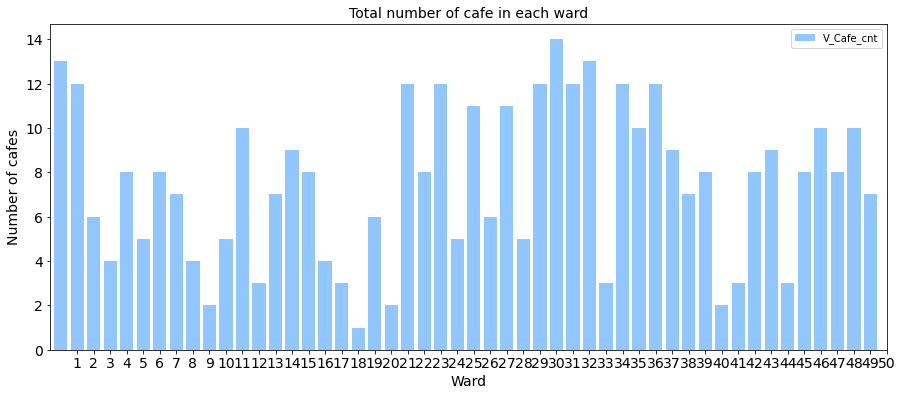

In [172]:
#--plot
mpl.style.use(["seaborn-pastel"])

chicago_data[["ward","V_Cafe_cnt"]].set_index("ward").plot(kind = "bar", figsize=(15,6), width = 0.8, fontsize = 14)
plt.title("Total number of cafe in each ward", fontsize = 14)
plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of cafes", fontsize = 14)
plt.xticks(chicago_data.ward, rotation= 0)

plt.show()
plt.close()

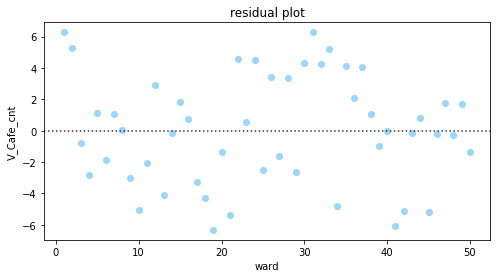

In [189]:
#--resplot 

plt.figure(figsize = (8,4))
sns.residplot(chicago_data["ward"], chicago_data["V_Cafe_cnt"], color = "lightskyblue")
plt.title("residual plot")
plt.show()

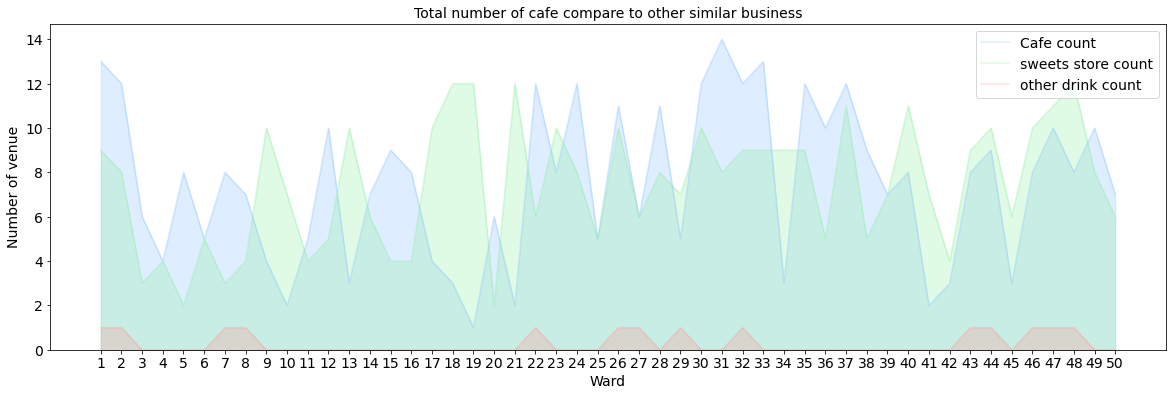

In [173]:
#--area plot

chicago_data[["ward","V_Cafe_cnt","V_Snack_cnt","V_Other_drinks_cnt"]].set_index("ward").plot(kind = "area", 
                                                                                              alpha = 0.3, 
                                                                                              stacked = False, 
                                                                                              figsize = (20,6),
                                                                                              fontsize = 14) 

plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of venue", fontsize = 14)
plt.title("Total number of cafe compare to other similar business", fontsize = 14)
plt.legend(labels = ["Cafe count","sweets store count","other drink count"],fontsize = 14)
plt.xticks(chicago_data.ward)
plt.show()

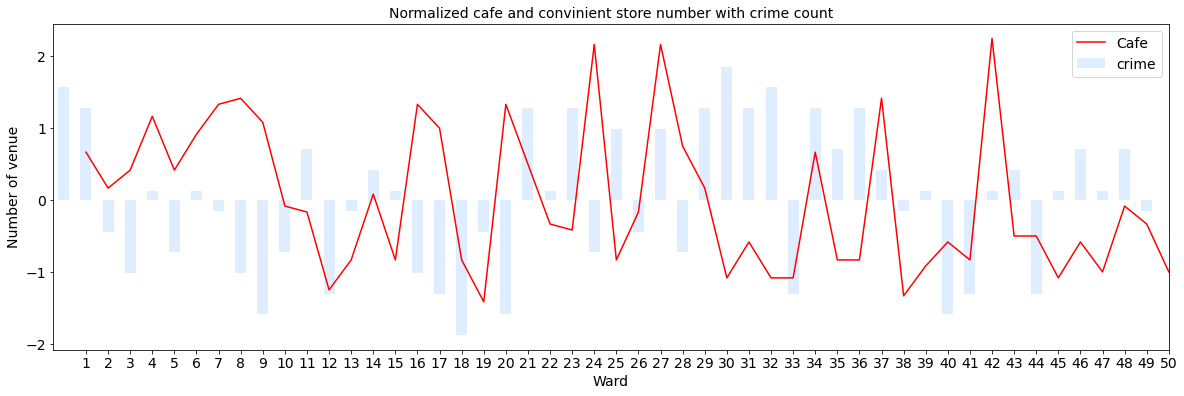

In [190]:
#--area plot adding in crime rate, after normalize the data

ax1 = chicago_data_normal[["V_Cafe_cnt"]].plot(kind = "bar", 
                                                                                              alpha = 0.3, 
                                                                                              stacked = False, 
                                                                                               figsize = (20,6),
                                                                                              fontsize = 14) 
plt.plot(chicago_data_normal[["C_Total_cnt"]], color = "red")

plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of venue", fontsize = 14)
plt.title("Normalized cafe and convinient store number with crime count", fontsize = 14)
plt.legend(labels = ["Cafe","crime"],fontsize = 14)
plt.xticks(chicago_data.ward, rotation = 0)
plt.show()

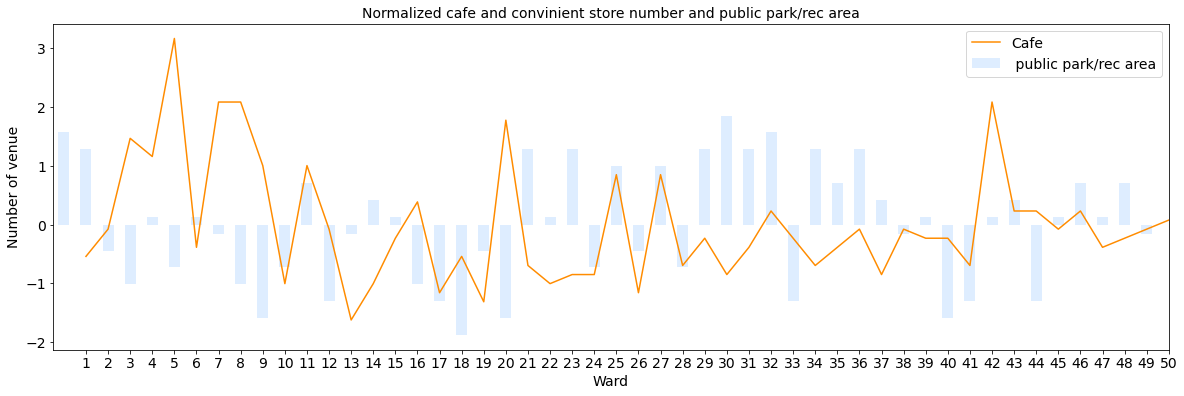

In [191]:
#--area plot adding in crime rate, after normalize the data

ax1 = chicago_data_normal[["V_Cafe_cnt"]].plot(kind = "bar", 
                                                                                              alpha = 0.3, 
                                                                                              stacked = False, 
                                                                                               figsize = (20,6),
                                                                                              fontsize = 14) 
plt.plot(chicago_data_normal[["V_Pub_Rec_Area_cnt"]], color = "darkorange")

plt.xlabel("Ward", fontsize = 14)
plt.ylabel("Number of venue", fontsize = 14)
plt.title("Normalized cafe and convinient store number and public park/rec area", fontsize = 14)
plt.legend(labels = ["Cafe"," public park/rec area"],fontsize = 14)
plt.xticks(chicago_data.ward, rotation = 0)
plt.show()

In [135]:
#--create clusters and kmean using the normalized data, but only include relevant variables

col_cafe = ["V_Cafe_cnt","Divvy_Station_cnt","LTrain_Stop_cnt","V_Snack_cnt","V_Other_drinks_cnt",
            #"V_Coworking Space_cnt",
            "V_Pub_Rec_Area_cnt","C_Total_cnt","C_Theft_cnt","C_Burglary_cnt"]
cluster_input = chicago_data_normal[col_cafe]

kclusters = 5

kmeans = KMeans(n_clusters = kclusters, random_state = 4).fit(cluster_input)
kmeans.labels_[0:5]

df_cluster = pd.DataFrame(kmeans.labels_).rename(columns = {0:"Cluster"})
df_cluster.head()

,Cluster
0,2
1,2
2,3
3,4
4,3


In [137]:
#--consolidate data back into the master dataset

chicago_data_cafe = pd.merge(chicago_data, df_cluster, left_index = True, right_index = True, how = "left")

chicago_data_cafe.head()

,ward,lat,lng,LTrain_Stop_cnt,Divvy_Station_cnt,C_Robbery_cnt,C_Burglary_cnt,C_Theft_cnt,C_Total_cnt,V_Cafe_cnt,V_Other_drinks_cnt,V_Snack_cnt,V_Pub_Rec_Area_cnt,V_Cafe_freq,V_Other_drinks_freq,V_Snack_freq,Top1_Venue,Top2_Venue,Top3_Venue,Cluster
0,1,41.928632,-87.678178,3.0,36.0,0.0,0.0,13.0,28.0,13.0,9.0,1.0,11.0,0.146067,0.101124,0.011236,Coffee Shop,Brewery,Ice Cream Shop,2
1,2,41.927232,-87.661367,7.0,49.0,0.0,0.0,13.0,22.0,12.0,8.0,1.0,14.0,0.139535,0.093023,0.011628,Coffee Shop,Brewery,Ice Cream Shop,2
2,3,41.855424,-87.618215,4.0,26.0,0.0,2.0,3.0,25.0,6.0,3.0,0.0,24.0,0.083333,0.041667,0.000000,Hotel,Grocery Store,New American Restaurant,3
3,4,41.873357,-87.625971,22.0,76.0,1.0,0.0,12.0,34.0,4.0,4.0,0.0,22.0,0.054054,0.054054,0.000000,Hotel,Grocery Store,New American Restaurant,4
4,5,41.805851,-87.583365,0.0,16.0,1.0,0.0,5.0,25.0,8.0,2.0,0.0,35.0,0.133333,0.033333,0.000000,Grocery Store,Hotel,Coffee Shop,3


In [201]:
#--plot the clusters fitting for cafe~

#--create map
chicago_map = folium.Map(location = [loc_lat, loc_lng], zoom_start = 11)

cluster_colors = ["skyblue", "white", "plum", "coral", "mediumseagreen", "red","gold"]
  

for lat, lng, neignbor, cluster in zip(chicago_data_cafe["lat"], chicago_data_cafe["lng"], 
                                    chicago_data_cafe["ward"], chicago_data_cafe["Cluster"]):
    label = folium.Popup("Ward: {}, Cluster: {}".format(neignbor,cluster), parse_html = True)
    folium.CircleMarker(location= [lat, lng], radius = 10, popup = label, 
                       color = "black", fill_color = cluster_colors[cluster],  
                        fill = True, fill_opacity = 0.9).add_to(chicago_map)

chicago_map

In [196]:
#--take a look at the clusters

chicago_data_cafe_plot = chicago_data_cafe[["ward"] + col_cafe + ["Cluster"]]

chicago_data_cafe_plot.iloc[:,1:].groupby("Cluster").mean()


,V_Cafe_cnt,Divvy_Station_cnt,LTrain_Stop_cnt,V_Snack_cnt,V_Other_drinks_cnt,V_Pub_Rec_Area_cnt,C_Total_cnt,C_Theft_cnt,C_Burglary_cnt
Cluster,,,,,,,,,
0,6.818182,4.636364,1.909091,0.000000,8.727273,10.727273,27.909091,5.000000,1.454545
1,7.529412,7.882353,2.176471,0.000000,7.882353,11.529412,9.529412,2.352941,0.176471
2,9.818182,26.272727,5.272727,1.000000,9.181818,12.909091,16.454545,6.181818,0.363636
3,7.166667,17.666667,0.833333,0.333333,3.000000,26.333333,32.500000,5.166667,1.833333
4,4.600000,71.000000,17.800000,0.200000,4.600000,22.200000,31.000000,12.000000,0.400000


In [202]:
#--check out cluster 0

chicago_data_cafe[chicago_data_cafe["Cluster"] == 0]  
chicago_data_cafe[chicago_data_cafe["Cluster"] == 1]  
#chicago_data_cafe[chicago_data_cafe["Cluster"] == 2]

chicago_data_cafe[["ward","Cluster","LTrain_Stop_cnt","Divvy_Station_cnt","V_Cafe_cnt","Top1_Venue","Top2_Venue","Top3_Venue"]][chicago_data_cafe["Cluster"] == 2]  #--top venue is all asian cuisine, it may be an asian neighborhood 



,ward,Cluster,LTrain_Stop_cnt,Divvy_Station_cnt,V_Cafe_cnt,Top1_Venue,Top2_Venue,Top3_Venue
0,1,2,3.0,36.0,13.0,Coffee Shop,Brewery,Ice Cream Shop
1,2,2,7.0,49.0,12.0,Coffee Shop,Brewery,Ice Cream Shop
21,22,2,5.0,11.0,12.0,Coffee Shop,Brewery,Pizza Place
25,26,2,3.0,23.0,11.0,Coffee Shop,Brewery,Pizza Place
28,29,2,0.0,0.0,5.0,Grocery Store,American Restaurant,Brewery
31,32,2,6.0,35.0,12.0,Coffee Shop,Brewery,Pizza Place
42,43,2,4.0,29.0,8.0,Coffee Shop,Liquor Store,Brewery
43,44,2,11.0,43.0,9.0,Coffee Shop,Grocery Store,Brewery
45,46,2,6.0,19.0,8.0,Coffee Shop,Brewery,Grocery Store
46,47,2,8.0,30.0,10.0,Coffee Shop,Grocery Store,Pizza Place
